# Simulating Predator-Prey Interaction

In [5]:
# used libraries

import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as so
import itertools as it

In [6]:
# differential equation system and solver method

def lotka_volterra(y0, params):
    '''
    

    Parameters
    ----------
    y0 : inital population,
        A: algae
        R: Rotifers
    params :
        ga: growing rate of algae without occurence of rotifer
        da: dying rate of algae due to rotifer consumption
        gr: growing rate of rotifer depending on occuring algae
        dr: dying rate of rotifer without algae occurance

    Returns
    -------
    numpy array of delta algae population, delta rotifer population

    '''

    

    A, R = y0

    ga, da, gr, dr = params

    

    da_dt = (ga * A) - (da * A * R)

    dr_dt = (gr * R * A) - (dr * R)

    

    return np.array([da_dt, dr_dt])





def RK4solver(time, y0, dfdt, params):
    '''
    

    Parameters
    ----------
    time : pandas Series of timepoints
    y0 : tuple of initial population of  (prey, predator)
    dfdt : differential equation system used
    params : parameters of differential equation system

    Returns
    -------
    numpy array of population sizes over simulated timepoints

    '''



    yn = y0

    ylist = [y0]
    
    time = np.array(time) # conversion into array


    for i in range(len(time)-1):
        
        # if decision for that dt doesn't get to high due to index - 1
        if i == 0:
            dt = time[i]
            
        else:
            dt = time[i] - time[i-1]  
            

        k1 = dt * dfdt(yn, params)

        k2 = dt * dfdt(yn + k1/2.,  params)

        k3 = dt * dfdt(yn + k2/2., params)

        k4 = dt * dfdt(yn + k3, params)


        yn1 = yn + 1/6 * (k1 + k2/2. + k3/2. + k4)

        yn = yn1

        ylist.append(yn)

        

    return np.array(ylist)

# Predicting ODE behaviour

In [151]:
# read in data fuction with some pandas transforms

def read_data(csv):

    data = pd.read_csv(csv)
    data = data.dropna()
    columns = [i for i in data.columns]

    time = np.array(data['time (days)'])
    liv_algae = data[' algae (10^6 cells/ml)'] * 10**2
    liv_rotifer = data[' rotifers (animals/ml)']
    dead_rotifer = data[' dead animals (per ml)']
    # x = [i for i in zip(x,x)]
    true = np.array([i for i in zip(liv_algae, liv_rotifer)], dtype = float)  # true data in some shape as RK4 return simulation

    data = pd.DataFrame({'time': time, 'algae (10^4 cells/ml)':liv_algae, 'rotifers (cells /ml)':liv_rotifer})
    return data

In [152]:
data = read_data('C1.csv')
data.head()

,time,algae (10^4 cells/ml),rotifers (cells /ml)
1,0.95,83.0,5.42
2,2.26,70.0,18.26
3,2.91,38.0,17.86
4,3.95,41.0,21.07
5,4.95,39.0,17.46


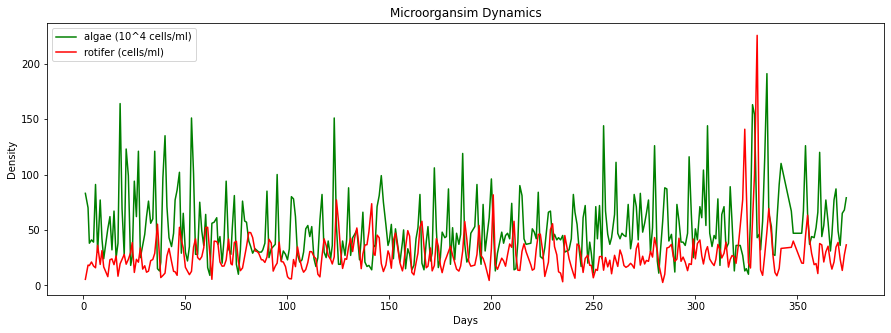

In [150]:
fig = plt.figure(figsize = (15,5))

plt.title('Microorgansim Dynamics')
plt.plot(data.iloc[:,0], data.iloc[:,1], label = 'algae (10^4 cells/ml)', color = 'green')
plt.plot(data.iloc[:,0], data.iloc[:,2], label = 'rotifer (cells/ml)', color = 'red')
plt.xlabel('Days')
plt.ylabel('Density')
plt.legend()

In [14]:
# defintion of an OLS

def OLS(true, prediction):
    return np.sum(np.square(true[:,0] - prediction[:,0])) + np.sum(np.square(true[:,1] - prediction[:,1]))

In [15]:
# minimize


y0 = (data.iloc[0,1], data.iloc[0,2])
time = data.iloc[:,0]
true = true = np.array([i for i in zip(data.iloc[:,1], data.iloc[:,2])], dtype = float)


x0 = (0.1, 0.006, 0.006, 0.1) # best guess from 

fun = lambda x: OLS(true, RK4solver(time, y0, lotka_volterra, params = (x[0], x[1], x[2], x[3]))) # anonymous func for scipy
bounds = ((0,1),(0,0.5), (0,0.5), (0,1)) # boundaries to prevent Runtime Warning an Resulting Nan arrays

res = so.minimize(fun = fun, x0 = x0, method = 'Nelder-Mead' , bounds = bounds) # nelder-mead from scipy optimize
res

 final_simplex: (array([[0.04289475, 0.00262786, 0.00715328, 0.41683831],
       [0.04289416, 0.00262778, 0.00715348, 0.41684705],
       [0.04289403, 0.00262778, 0.00715336, 0.41684357],
       [0.04289294, 0.00262776, 0.00715351, 0.41685421],
       [0.04289316, 0.00262776, 0.00715354, 0.41685705]]), array([612146.01656263, 612146.0165701 , 612146.0165824 , 612146.01663378,
       612146.0166466 ]))
           fun: 612146.0165626304
       message: 'Optimization terminated successfully.'
          nfev: 406
           nit: 240
        status: 0
       success: True
             x: array([0.04289475, 0.00262786, 0.00715328, 0.41683831])

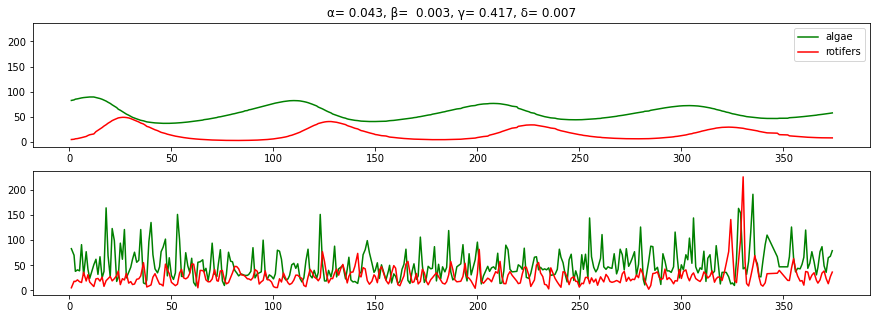

In [16]:
# to compare the output of the minimizing approach

y0 = (data.iloc[0,1], data.iloc[0,2])
time = data.iloc[:,0]

ga, da, gr, dr = res.x # unpacking

fig , axs = plt.subplots(2,1, figsize = (15,5), sharey = True)
p = RK4solver(time = time, y0 =  y0, dfdt =  lotka_volterra, params = (ga, da, gr, dr))
axs[0].plot(time, p[:,0], label = 'algae', color = 'green')
axs[0].plot(time, p[:,1], label = 'rotifers',color = 'red')
axs[0].set_title(('α= {}, β=  {}, γ= {}, δ= {}').format(round(ga,3),round(da,3), round(dr, 3),round(gr, 3)))
axs[0].legend()
axs[1].plot(time, data.iloc[:,1], color = 'green')
axs[1].plot(time, data.iloc[:,2], color = 'red')

Text(0, 0.5, 'Population density')

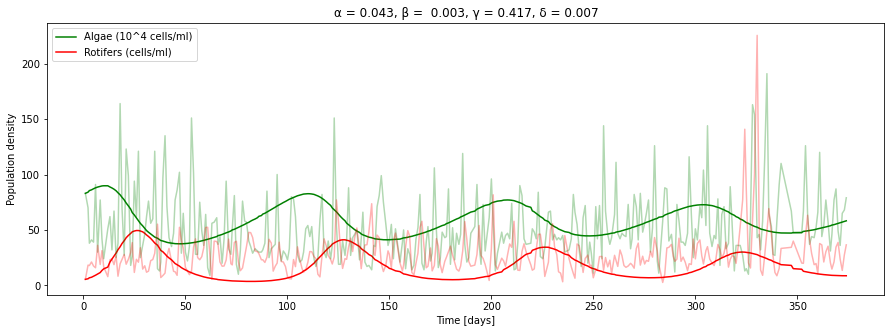

In [100]:
# plot for presentations

y0 = (data.iloc[0,1], data.iloc[0,2])
time = data.iloc[:,0]

ga, da, gr, dr = res.x # unpacking optimized result

fig = plt.figure(figsize = (15,5))
p = RK4solver(time = time, y0 =  y0, dfdt =  lotka_volterra, params = (ga, da, gr, dr)) # simulating optimized result
plt.plot(time, p[:,0], label = 'Algae (10^4 cells/ml)', color = 'green')
plt.plot(time, p[:,1], label = 'Rotifers (cells/ml)',color = 'red')
plt.title(('α = {}, β =  {}, γ = {}, δ = {}').format(round(ga,3),round(da,3), round(dr, 3),round(gr, 3)))
plt.legend()
plt.plot(time, data.iloc[:,1], color = 'green', alpha = .3)
plt.plot(time, data.iloc[:,2], color = 'red', alpha = .3)
plt.xlabel('Time [days]')
plt.ylabel('Population density')

### alter initial population

In [18]:
# minimize


y0 = (data.iloc[0,1] , data.iloc[0,2])
time = data.iloc[:,0]
true = true = np.array([i for i in zip(data.iloc[:,1], data.iloc[:,2])], dtype = float)


x0 = (.5, .001, .001, .5) # some more or less random initial guess

fun = lambda x: OLS(true, RK4solver(time, y0, lotka_volterra, params = (x[0], x[1], x[2], x[3]))) # anonymous func for scipy
bounds = ((0,1),(0,0.01), (0, 0.01), (0, 1)) # boundaries to prevent Runtime Warning an Resulting Nan arrays

res = so.minimize(fun = fun, x0 = x0, method = 'Nelder-Mead' , bounds = bounds, options = {'maxiter' : 1000}) 
print(res)
print(y0)

 final_simplex: (array([[0.        , 0.0001946 , 0.00102566, 0.05740155],
       [0.        , 0.0001946 , 0.00102563, 0.05739998],
       [0.        , 0.0001946 , 0.00102567, 0.0574022 ],
       [0.        , 0.00019459, 0.00102568, 0.05740344],
       [0.        , 0.00019459, 0.00102566, 0.05740218]]), array([626508.67731104, 626508.67733898, 626508.67735216, 626508.67735424,
       626508.67736193]))
           fun: 626508.6773110374
       message: 'Optimization terminated successfully.'
          nfev: 395
           nit: 228
        status: 0
       success: True
             x: array([0.        , 0.0001946 , 0.00102566, 0.05740155])
(83.0, 5.42)


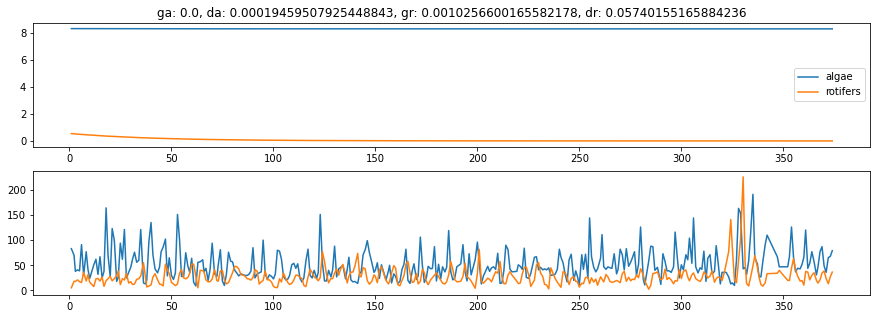

In [19]:
# to compare the output of the minimizing approach

y0 = (data.iloc[0,1] / 10, data.iloc[0,2] / 10)
time = data.iloc[:,0]

ga, da, gr, dr = res.x # unpacking

fig , axs = plt.subplots(2,1, figsize = (15,5))
p = RK4solver(time = time, y0 =  y0, dfdt =  lotka_volterra, params = (ga, da, gr, dr))
axs[0].plot(time, p[:,0], label = 'algae')
axs[0].plot(time, p[:,1], label = 'rotifers')
axs[0].set_title(('ga: {}, da: {}, gr: {}, dr: {}').format(ga, da, gr, dr))
axs[0].legend()
axs[1].plot(time, data.iloc[:,1])
axs[1].plot(time, data.iloc[:,2])

##### Problems
Much fewer cycles in simulation that in real data, there seems to be quite some noice in the real world data. akos' suggestion was to maybe fit my func to kind of rolling avg of the data.

### window avg to reduce 'noise'
--> turned out be oscillation cycles due to short generation time, not noise ==> function not useful

In [20]:
# creating dataset with avg data points every window-step to minimize noise

def window_avg(data, window, plot):

    data_avg = data.copy(deep = True)

    for i in range(0, len(data.iloc[:,1]), window): # loop through every windowth row of data:

        if (len(data.iloc[:,1]) - i) > window:      # if-else for problem of ith window not matching length of data
            window = window
        else:
            window = len(data.iloc[:,1]) - i

        roll = list(np.array(range(0, window)) + i)

        data_avg.iloc[i, 1] =  np.sum(data.iloc[roll, 1]) / window  # creating new data set with average every windowth point
        data_avg.iloc[i, 2] =  np.sum(data.iloc[roll, 2]) / window
        data_avg.iloc[roll[1:], 1] = np.nan # setting other points to nans to drop them later on
        data_avg.iloc[roll[1:], 2] = np.nan
        
        

    data_avg = data_avg.dropna()

    # plot the results
    if plot == True:

        plt.figure(figsize = (15,5))
        plt.title('window = ' + str(window))
        plt.plot(data_avg.iloc[:,0], data_avg.iloc[:,1], label = 'algae', marker = 'o')
        plt.plot(data_avg.iloc[:,0], data_avg.iloc[:,2], label = 'rotifer', marker  ='o')
        plt.legend()
    
    return data_avg


In [21]:
def minimizer(data,  x0 = (0.1, 0.006, 0.006, 0.1)):    # some more or less random initial guess
    y0 = (data.iloc[0,1], data.iloc[0,2])
    time = data.iloc[:,0]
    
    true_data = np.array([i for i in zip(data.iloc[:,1], data.iloc[:,2])], dtype = float)


    fun = lambda x: OLS(true_data, RK4solver(time, y0, lotka_volterra, params = (x[0], x[1], x[2], x[3]))) # anonymous func for scipy
    bounds = ((0,1),(0,0.5), (0,0.5), (0,1)) # boundaries to prevent Runtime Warning an Resulting Nan arrays

    res = so.minimize(fun = fun, x0 = x0, method = 'Nelder-Mead' , bounds = bounds) # minimizer func from statsmodels
    
    return res

In [22]:
def plot_optimum(data, res):
    y0 = (data.iloc[0,1], data.iloc[0,2]) # initial population
    time = data.iloc[:,0] # timeline

    ga, da, gr, dr = res.x # unpacking of optimizer params

    fig , axs = plt.subplots(2,1, figsize = (15,5), sharex = True)
    p = RK4solver(time = time, y0 =  y0, dfdt =  lotka_volterra, params = (ga, da, gr, dr)) # plot simulation
    axs[0].plot(time, p[:,0], label = 'algae')
    axs[0].plot(time, p[:,1], label = 'rotifers')
    axs[0].set_title(('ga: {}, da: {}, gr: {}, dr: {}').format(ga, da, gr, dr))
    axs[0].legend()
    axs[1].plot(time, data.iloc[:,1])
    axs[1].plot(time, data.iloc[:,2])

In [23]:

def compare(data, windows):
    '''
    data: pandas dataset
    windows: list of windows    
    '''
    for window in windows:
        data_avg = window_avg(data, window, False)
        res = minimizer(data_avg)
        plot_optimum(data_avg, res)
        
        
        

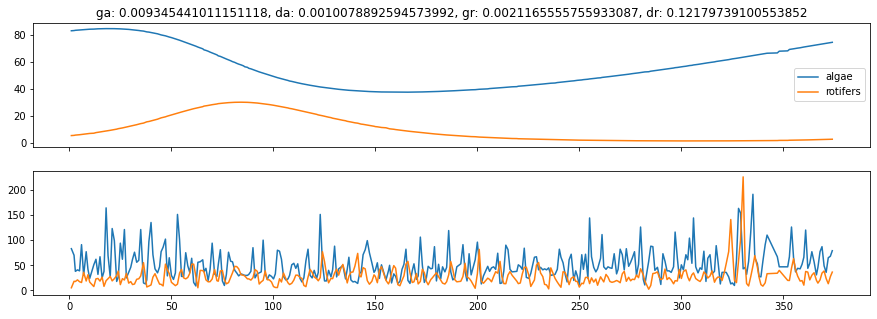

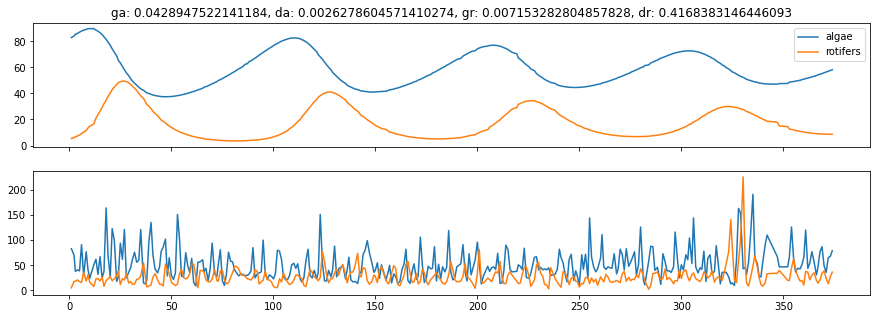

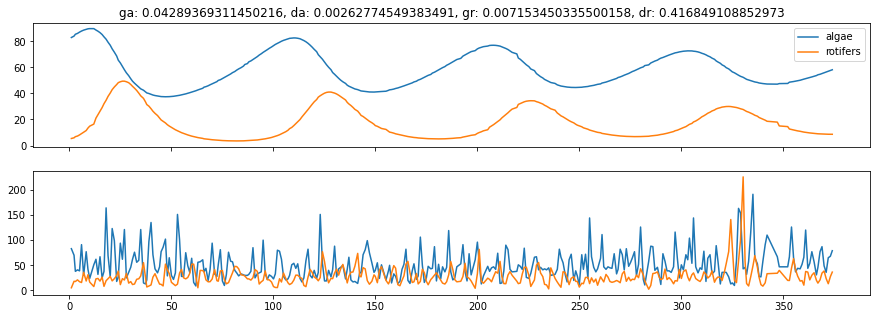

In [24]:
# check wether initial guess has influence

guesses = [(0.1, 0.001, 0.001, 0.1), (0.1, 0.006, 0.006, 0.1), (0.3, 0.003, 0.003, 0.3)]

for g in guesses:
    plot_optimum(data = data, res = minimizer(data, x0 = g))


### Extrapolating system decrease

In [25]:
# extrapolting system decrease

# maxima of algae

def sort_points(points,top):

    top_algae = points[points[:, 0].argsort()][-top:-1]
    top_rotifer = points[points[:, 1].argsort()][-top:-1]

    return top_algae, top_rotifer

# approach doesn't satisfy, we have to define some sliding window equal to cycle size



def find_max(points, cycle_size):

    max_algae = []
    max_rotifer = []

    for i in range(0, len(points), cycle_size):
        max_a = max(points[i:i+cycle_size], key = lambda x: x[0]) #
        max_r = max(points[i:i+cycle_size], key = lambda x: x[1])

        max_algae.append(list(max_a))
        max_rotifer.append(list(max_r))

    return np.array(max_algae), np.array(max_rotifer)



In [102]:
# function to plot maxima

def get_max(time, res, cycle_size, plot = False):
        
    # create simulated points

    sim = RK4solver(time, y0, lotka_volterra, tuple(res.x))

    sim = np.array(list(zip(sim[:,0], sim[:,1],time)))

    # find max of simulated points in window 100

    tops_alg, tops_rot  = find_max(sim, cycle_size)

    # converting into pd frames

    sim = pd.DataFrame(sim)
    sim.columns = ['Algae', 'Rotifer' , 'Time']

    tops_alg = pd.DataFrame(tops_alg)
    tops_alg.columns = ['Max Algae', 'Max Rotifer', 'Time']
    tops_alg = tops_alg.drop(labels = 'Max Rotifer', axis = 1)

    tops_rot = pd.DataFrame(tops_rot)
    tops_rot.columns = ['Max Algae', 'Max Rotifer', 'Time']
    tops_rot = tops_rot.drop(labels = 'Max Algae', axis = 1)
    
    if plot == True:
    
        plt.figure(figsize = (15,5))
        plt.plot(sim.iloc[:,2], sim.iloc[:,0], label = 'Algae (10^4 cells/ml)', color = 'green')
        plt.plot(sim.iloc[:,2], sim.iloc[:,1], label = 'Rotifer (cells/ml)', color = 'red')
        plt.scatter(tops_alg.iloc[:,1], tops_alg.iloc[:, 0], label = 'Cycle top', color = 'black')
        plt.scatter(tops_rot.iloc[:,1],tops_rot.iloc[:, 0], color = 'black')
        
    
    return sim, tops_alg, tops_rot


def plot_max(time, res, cycle_size):
    
    sim, tops_alg, tops_rot = get_max(time, res, cycle_size)
    
    # plotting results of cycle tops

    plt.figure(figsize = (15,5))
    plt.plot(sim.iloc[:,2], sim.iloc[:,0], label = 'Algae', color = 'green')
    plt.plot(sim.iloc[:,2], sim.iloc[:,1], label = 'Rotifer', color = 'red')
    plt.scatter(tops_alg.iloc[:,1], tops_alg.iloc[:, 0], label = 'Top', color = 'black')
    plt.scatter(tops_rot.iloc[:,1],tops_rot.iloc[:, 0], color = 'black')
    plt.legend()
    


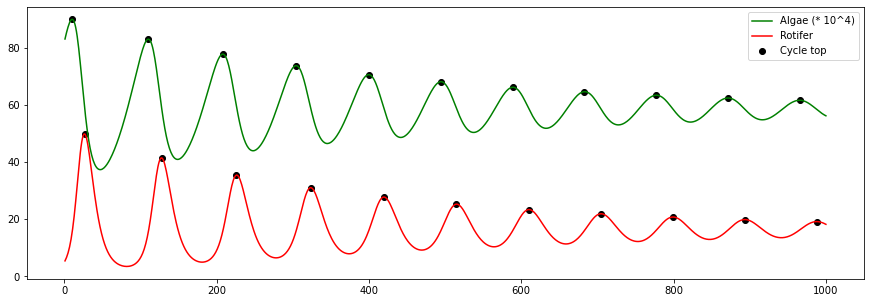

In [30]:
# import data

data = read_data('C1.csv')
y0 = (data.iloc[:,1][1], data.iloc[:,2][1])

# minimize

res = minimizer(data)

# plot a further timeline as above

time = np.linspace(1,1000, 1000)
cycle_size = 91

sim, tops_alg, tops_rot = get_max(time = time, res = res, cycle_size = cycle_size, plot = True) # calculating tops und plot them
plt.legend()
plt.show()

In [144]:
# define neg exponential function and define params

def neg_exp(t, a, b, c):
    
    return a  * np.exp(-b * t) + c

# fit exoponential function

def fit_exp(t, y, func, p0):
    
    params, _  = so.curve_fit(f = func, xdata =  t, ydata =  y, p0 = p0, maxfev = 100000)
    
    return params

# plot the fitted curve

def plot_exp(time, params, style, color, alpha, label):
    
    plt.plot(time, neg_exp(time, *params), color = color, linestyle = style, alpha = alpha, label = label)
    
    return params

#### algae tops

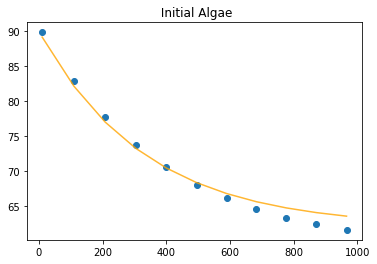

In [146]:
# find a good intial guess for algae
    
time = tops_alg.iloc[:,1]
param = [28,.003,62] # params manually adjusted to be more or less close to tops
    
# plot

plt.scatter(tops_alg.iloc[:,1], tops_alg.iloc[:,0]) # algae tops
plot_exp(time, param, style = '-', color ='orange', alpha  = .8, label = None)
plt.title(' Initial Algae')
plt.show()



#### rotifer tops

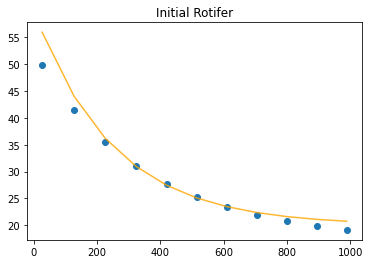

In [147]:
# find a good intial guess for algae
    
time = tops_rot.iloc[:,1]
param = [40,.004,20]
    
# plot

plt.scatter(tops_rot.iloc[:,1], tops_rot.iloc[:,0])
plot_exp(time, param, style = '-', color ='orange', alpha  = .8, label = None)
plt.title('Initial Rotifer')

plt.show()

In [35]:
#store initial guesses:

p0_alg = [28, 0.003, 62]
p0_rot = [40, 0.004, 20]

#### fit the exp to tops

In [36]:
# import data

data = read_data('C1.csv')

# minimize

res = minimizer(data)

# plot a further timeline as above

time = np.linspace(1,1000, 1000)

# call get_max for frames

sim, tops_alg, tops_rot = get_max(time, res, cycle_size)

# fit function for algae

t_alg = np.array(tops_alg.iloc[:,1])
y_alg = np.array(tops_alg.iloc[:,0])

alg_params = fit_exp(t = t_alg, y = y_alg, func = neg_exp, p0 = p0_alg)

# optimize curve for rotifers

t_rot = np.array(tops_rot.iloc[:,1])
y_rot = np.array(tops_rot.iloc[:,0])

rot_params = fit_exp(t = t_rot, y = y_rot, func = neg_exp,  p0 = p0_rot)
              
    
print(rot_params, alg_params)

[3.51070984e+01 2.88444832e-03 1.72370121e+01] [3.18861776e+01 2.48713983e-03 5.87266427e+01]


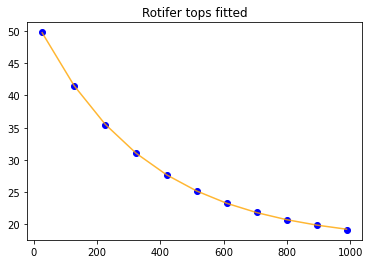

In [37]:
# check fitted exp function for rotifer
    
time = tops_rot.iloc[:,1]
    
# plot

plt.scatter(tops_rot.iloc[:,1], tops_rot.iloc[:,0], color = 'blue')
plot_exp(time  = tops_rot.iloc[:, 1], params = rot_params, style = '-', color ='orange', alpha  = .8)
plt.title('Rotifer tops fitted')

plt.show()

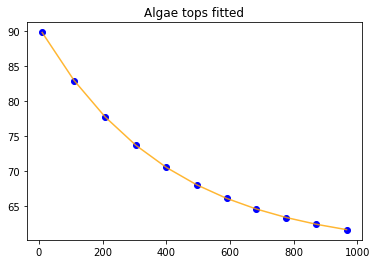

In [38]:
# plot fitted parameters for algae

plt.scatter(tops_alg.iloc[:,1], tops_alg.iloc[:,0], color = 'blue')
plot_exp(time  = tops_alg.iloc[:, 1], params = alg_params, style = '-', color ='orange', alpha  = .8)
plt.title('Algae tops fitted')

plt.show()

In [104]:
# import data

data = read_data('C1.csv')
y0 = (data.iloc[0,1], data.iloc[0,2])

# minimize

res = minimizer(data)

# plot a further timeline as above

time = np.linspace(1,1000, 1000)
cycle_size = 91

data.head()

,time,algae (10^4 cells/ml),rotifers (cells /ml),dead rotifers (cells/ml)
1,0.95,83.0,5.42,0.4
2,2.26,70.0,18.26,0.0
3,2.91,38.0,17.86,0.4
4,3.95,41.0,21.07,0.4
5,4.95,39.0,17.46,0.2


### plot exponential descrease

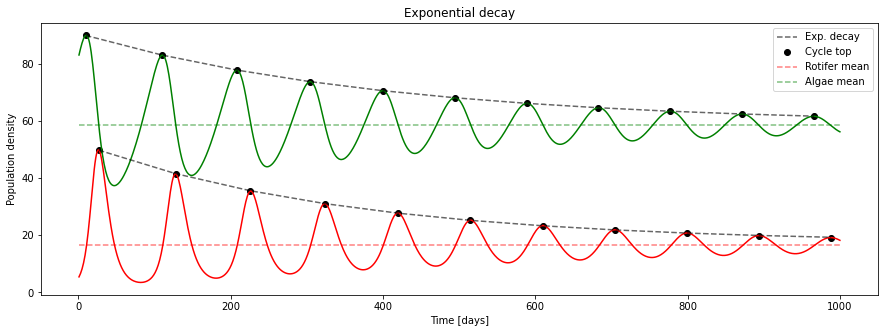

,Algae,Rotifer,Time
0,83.000000,5.420000,1.0
1,84.145396,5.973146,2.0
2,85.234383,6.611030,3.0
3,86.253269,7.346544,4.0
4,87.186357,8.194122,5.0


In [143]:
# first run simulation and extract tops

sim, tops_alg, tops_rot = get_max(time = time, res = res, cycle_size = cycle_size, plot = False)

# plot simulation

plt.figure(figsize = (15,5))
plt.plot(sim.iloc[:,2], sim.iloc[:,0], color = 'green')
plt.plot(sim.iloc[:,2], sim.iloc[:,1],  color = 'red')
plt.scatter(tops_alg.iloc[:,1], tops_alg.iloc[:, 0], label = 'Cycle top', color = 'black')
plt.scatter(tops_rot.iloc[:,1],tops_rot.iloc[:, 0], color = 'black')

# plotting the fitted exponential functions

plot_exp(time  = tops_rot.iloc[:, 1], params = rot_params, style = '--', color = 'black', alpha = .6, label = 'Exp. decay')
plot_exp(time  = tops_alg.iloc[:, 1], params = alg_params, style = '--',color = 'black', alpha = .6, label = None)

# plots the overall mean of each curve

plt.hlines(np.mean(sim.iloc[:,1]), xmin = min(sim.iloc[:,2]), xmax = max(sim.iloc[:,2]), 
           linestyles = 'dashed', color = 'red', alpha = .5, label = 'Rotifer mean')
plt.hlines(np.mean(sim.iloc[:,0]), xmin = min(sim.iloc[:,2]), xmax = max(sim.iloc[:,2]), 
           linestyles = 'dashed', color = 'green',alpha = .5, label = 'Algae mean')

# axis and titles set

plt.title('Exponential decay')
plt.xlabel('Time [days]')
plt.ylabel('Population density')
plt.legend()
plt.show()

sim.head()

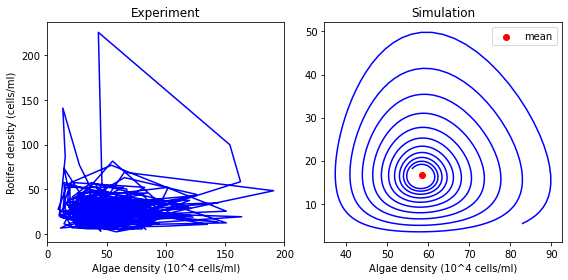

In [129]:
# visualizing appoximating to mean

fig, axs = plt.subplots(1,2, figsize = (8,4) )

# plot algae against rotfer

axs[0].plot(data.iloc[:,1], data.iloc[:,2], color = 'blue')
axs[1].plot(sim.iloc[:,0], sim.iloc[:,1], color = 'blue')

# plot means

axs[0].scatter(np.mean(data.iloc[:,1]), np.mean(data.iloc[:,2]), color = 'red', label = 'mean')
axs[1].scatter(np.mean(sim.iloc[:,0]), np.mean(sim.iloc[:,1]), color = 'red', label = 'mean')

# somehow mean of dataset is not plotted:( 

axs[0].set_title('Experiment')
axs[0].set_xlabel('Algae density (10^4 cells/ml)')
axs[0].set_ylabel('Rotifer density (cells/ml)')
axs[1].set_title('Simulation')
axs[1].set_xlabel('Algae density (10^4 cells/ml)')

plt.legend()

plt.tight_layout()

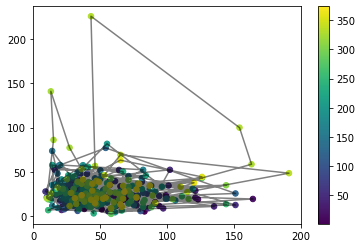

In [74]:
plt.plot(data.iloc[:,1], data.iloc[:,2], color = 'black', alpha = .5)
plt.scatter(data.iloc[:,1], data.iloc[:,2], c = data.iloc[:,0], s = 30)
plt.colorbar()

42.81


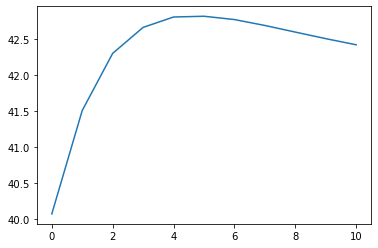

In [87]:
# is distance between tops getting bigger

d_decrease = np.array(tops_alg.iloc[:,0]) - np.array(tops_rot.iloc[:, 0])

plt.plot(d_decrease)
print(round(max(d_decrease), 2))
# makes no sense bc time of tops not sampe, compare functions

In [ ]:
data[data.columns[2]]

In [110]:
def get_rolling(data, column_index, window, plot = False, alpha = None, color = None, fill_alpha = None):
    # sim, _ , _ = get_max(time = time, res = res, cycle_size = cycle_size, plot = False)
    data_rollmean = data[data.columns[column_index]].rolling(window).mean()
    data_rollstd = data[data.columns[column_index]].rolling(window).std()
                        
    if plot == True:
        
        plt.plot(data_rollmean.index, data_rollmean, color = color, alpha = alpha, label = 'rolling mean +/- std')
        plt.plot(data_rollmean.index, data_rollmean + data_rollstd, color = color, alpha = alpha)
        plt.plot(data_rollmean.index,data_rollmean - data_rollstd, color = color, alpha = alpha)
        plt.fill_between(data_rollmean.index, data_rollmean - data_rollstd, data_rollmean + data_rollstd, color = color,
                         alpha =  fill_alpha, label = 'rolling standard deviation')
                        
        
        
    
    return data_rollmean, data_rollstd
# maybe better to introduce

Text(0.5, 0, 'Time')

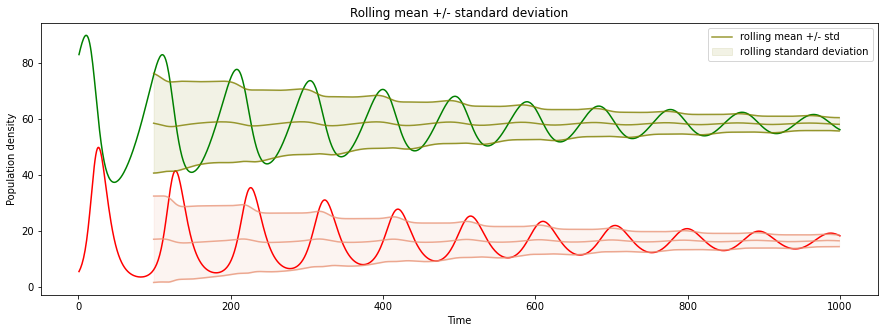

In [116]:
# plot rolling standard deviation and mean

plt.figure(figsize = (15,5))
plt.plot(sim.iloc[:,2], sim.iloc[:,0], color = 'green')
plt.plot(sim.iloc[:,2], sim.iloc[:,1],  color = 'red')
alg_rollmean , alg_rollstd = get_rolling(sim, 0, 100, plot = True, alpha = .8, color = 'olive', fill_alpha = .1)
plt.legend()
rot_rollmean, rot_rollstd = get_rolling(sim, 1, 100, plot = True, alpha = .8, color = 'darksalmon', fill_alpha = .1)
plt.title('Rolling mean +/- standard deviation')
plt.ylabel('Population density')
plt.xlabel('Time')



In [124]:
# decrease of cyle dynamic

print(alg_rollmean[100]-alg_rollmean[999])
print(alg_rollstd[100]-alg_rollstd[900])
print(rot_rollstd[100]-rot_rollstd[900])

0.3285426497354038
14.834373490378486
12.792452499080197


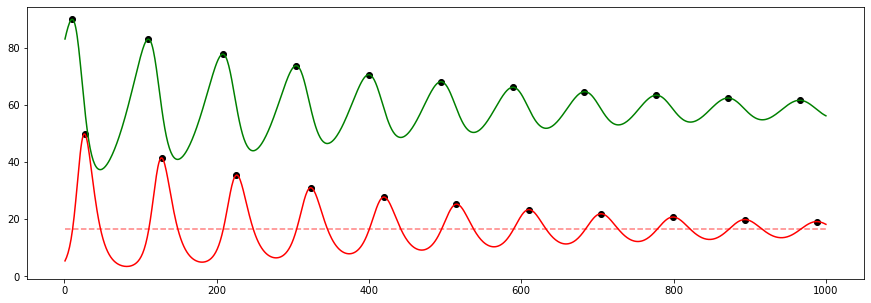

In [90]:
sim, _ , _ = get_max(time = time, res = res, cycle_size = cycle_size, plot = True)
plt.hlines(np.mean(sim.iloc[:,1]), xmin = min(sim.iloc[:,2]), xmax = max(sim.iloc[:,2]), linestyles = 'dashed', color = 'red',alpha = .5)

In [92]:
np.array(np.mean(sim.iloc[:,1]))


array(16.65221665)

In [93]:
sim.head()

,Algae,Rotifer,Time
0,83.000000,5.420000,1.0
1,84.145396,5.973146,2.0
2,85.234383,6.611030,3.0
3,86.253269,7.346544,4.0
4,87.186357,8.194122,5.0


Text(0, 0.5, 'delta')

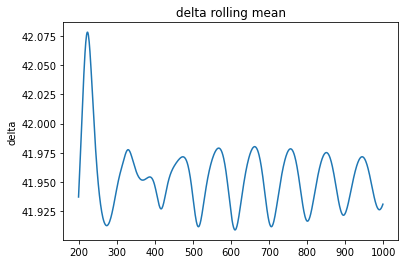

In [99]:
plt.plot((alg_rollmean - rot_rollmean).rolling(100).mean())
plt.hline
plt.title('delta rolling mean')
plt.ylabel('delta')

In [ ]:
# population becomes stable, predator learn how to conusme algae over time to not die out

# extrapolate: np.sort(), fit with exp decay exp(-at). get coeffiecent tell me speed system reaches equi
# animation
# plots of algae vs rotifers

In [ ]:
# find euilibrium point of system
# rollig avg
